# The Modflow Water Budget
This tutorial will teach you how to obtain and manipulate water budget data. The MODFLOW documentation states ([Harbaugh, 2005, p. 3-9](https://pubs.usgs.gov/tm/2005/tm6A16/PDF.htm)):

> A summary of all inflows (sources) and outflows (sinks) of water to a region is generally called a water budget. In this report, the water budget is termed a volumetric budget because volumes of water and volumetric flow rates are involved; thus strictly speaking, a volumetric budget is not a mass balance, although this term has been used in other model reports. The model program calculates a water budget for the overall model as a check on the acceptability of the solution, and to provide a summary of the sources and sinks of water to the flow system. 

> The total budget as printed in the output does not include internal flows between model cells—only flows into or out of the model as a whole. For example, flow to or from rivers, flow to or from constant-head cells, and flow to or from wells are all included in the overall budget terms. Flow into and out of storage is also considered part of the overall budget inasmuch as accumulation in storage effectively removes water from the flow system and storage release effectively adds water to the flow—even though neither process, in itself, involves the transfer of water into or out of the ground-water regime. Each hydrologic package calculates its own contribution to the budget. 

*Note: Because the water budget is volumetric, for our purposes it is m^3/day.*

**For more information** about the water budget see chapters 3 and 4 in the [MODFLOW documentation](https://pubs.usgs.gov/tm/2005/tm6A16/PDF.htm).

---

## 1. Import packages and define variables we need

In [1]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt  #necessary tool for creating and formatting plots
import flopy.utils.binaryfile as bf

#Jupyter specific--included to show plots in notebook
%matplotlib inline 


#---------------------
#Define model name to be called later
modelname = "example_model"  

#Variables we need
## Discretization
nrow = 50        #number of rows
ncol = 50        #number of columns
dx = 100.        #width in x
dy = 100.        #width in y
nper = 4

## Well info
pumping_rate1 = 0      #m3/day 
pumping_rate2 = -2500  #m3/day 
pumping_rate3 = -5000  #m3/day 
well_xy= [2000, 1500]  #xy location of well 
well_row = np.floor((nrow-1)-(well_xy[1]/dy))  #convert the y location to a row
well_col=np.floor(well_xy[0]/dx-1)             #convert the x location to a column
well_loc = (0,well_row,well_col)               #Well loc should be layer, row, column
# print("Well [layer, row, column, flux]: \n", well)

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/flopy


## 2. Get binary data
We want to read in information from the binary files (head file and cbc file), which contain the budget values. You can learn more about the Flopy binary utilities [here](https://modflowpy.github.io/flopydoc/binaryfile.html).

Once the budget object is created and read in, you can see what values it contains. Values like ET, recharge, and leakage will only appear if that package is in use. In order to get storage, the 'storagecoefficient' needs to equal **True** in the LPF package. Storage *only appears after transient changes* in the water budget.
> lpf = flopy.modflow.ModflowLpf(m, laytyp=cnf, hk=Kh, vka=Kz, ss=ss, sy=Sy, **storagecoefficient=True**, ipakcb=53)

In [2]:
#Extract binary data from head and budget files using bf (imported above)
headobj = bf.HeadFile(modelname+'.hds')        #get head data as python object
budgobj = bf.CellBudgetFile(modelname+'.cbc')  #get flow data as python object
times = headobj.get_times()                    #get times from headobj

#View the available water budget variables
print('Printing unique budget names...',budgobj.get_unique_record_names())

#View the times used
print('Transient timesteps...', times) #these times start counting after the 7 days of steady-state

Printing unique budget names... [b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'   RIVER LEAKAGE', b'              ET', b'        RECHARGE', b'         STORAGE']
Transient timesteps... [7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0]


## 3. Pulling stuff out of the Water budget
The head values for the model are stored in the headobj, whereas the budgobj stores other values (e.g. Leakage, ET, etc.)
Here we create dictionaries to store the water budget information from each stress period. If your model has a single stress period, then the you can just read in the water budget like this:

> leakage = budgobj.get_data(text='RIVER LEAKAGE')

For this example, we need to account for the various stress periods and time steps. The syntax **'sp%s'%(stress_per)** is a replace method, so we can read in all the data. The **'sp%s'** also creates the dictionary keys that we will need later to access specific parts of the data.

In [3]:
#Get data from python objects
head = {}        #create dictionary to store head data at the end of each stress period
frf = {}         #create dictionary to store flows through right cell face at the end of each stress period
fff = {}         #create dictionary to store flows through front cell face at the end of each stress period
storage = {}     #create dictionary to store storage changes at the end of each stress period
consthead = {}   #create dictionary to store constant head data at the end of each stress period
leakage = {}     #create dictionary to store leakage values at the end of each stress period
recharge = {}    #create dictionary to store recharge values at the end of each stress period
et = {}          #create dictionary to store ET values at the end of each stress period


for stress_per, time in enumerate(times):                                              #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time)                           #append heads to head list for each stress period
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time)     #returns array of flow rates for right face of cells 
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time)     #returns array of flow rates for front face of cells 
    storage['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)         #returns array of volumetric storage changes
    consthead['sp%s'%(stress_per)] = budgobj.get_data(text='CONSTANT HEAD',totim=time) #returns array of flow into/out of constant head cells
    leakage['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time)   #returns array of flow rates from river leakage into/out of cells
    recharge['sp%s'%(stress_per)] = budgobj.get_data(text='RECHARGE', totim=time)      #returns array of flow rates for recharge into cells 
    et['sp%s'%(stress_per)] = budgobj.get_data(text='ET', totim=time)                  #returns array of flow rates for ET out of cells

### Pulling out specific data
If we want to look at what is contained in the dictionary, we can print out data for a specific stress period or for all stress periods. The syntax to access the data can be confusing at first, so if you have not read about different data types in Python head over to the 'Flopy_data_structures_tutorial' to read about them before we continue.

We will use the constant head dictionary as our example. We created a dictionary to store the constant head values called *'consthead'*. We can print the entire dictionary, but it is long. We expect it to be 22 entries long because we have three transient stress periods with 7 timesteps each (21) and one steady-state stress period with one timestep (1). 

In [4]:
#Print length of Constant head dictionary
print('Length of consthead =', len(consthead))

#Print the Constant head dictionary
# print('Printing entire Constant head dictionary......', consthead)

Length of consthead = 22


To access values in a dictionary, we need to refer to them by their 'key'. In this case, our keys are strings that start with sp and end with the number of the timestep (e.g. 'sp0' is the key to access data contained in timestep 1). The length of consthead['sp%s'] is always 1 because there is only data for that timestep.

In [5]:
#Print length and values from timestep 10
print('Length of timestep 10 =', len(consthead['sp9']))  
print('Printing timestep 10.....', consthead['sp9'])

Length of timestep 10 = 1
Printing timestep 10..... [rec.array([(   1, -2195.7068 ), (  50,  -746.3832 ), (  51, -2195.6328 ),
           ( 100,  -746.2561 ), ( 101, -2195.4795 ), ( 150,  -745.9985 ),
           ( 151, -2195.2358 ), ( 200,  -745.60236), ( 201, -2194.8838 ),
           ( 250,  -745.0549 ), ( 251, -2194.3965 ), ( 300,  -744.3358 ),
           ( 301, -2193.7332 ), ( 350,  -743.4131 ), ( 351, -2192.8318 ),
           ( 400,  -742.2348 ), ( 401, -2191.589  ), ( 450,  -740.70984),
           ( 451, -2189.8135 ), ( 500,  -738.65924), ( 501, -2187.085  ),
           ( 550,  -735.6771 ), ( 551, -2185.303  ), ( 600,  -733.6768 ),
           ( 601, -2184.0476 ), ( 650,  -732.2511 ), ( 651, -2183.1265 ),
           ( 700,  -731.2188 ), ( 701, -2182.4348 ), ( 750,  -730.4849 ),
           ( 751, -2181.9084 ), ( 800,  -729.9914 ), ( 801, -2181.505  ),
           ( 850,  -729.6977 ), ( 851, -2181.1936 ), ( 900,  -729.5712 ),
           ( 901, -2180.9521 ), ( 950,  -729.5817 ), ( 951,

After the key, we can specify a value to pull out. However this value refers to a recarray. There is only one recarray contained within each key, so we will just use [0]. After the key, we can put integers in brackets to get the cell column, and then the cell ID or flux value.

In [6]:
print('Flux in the in middle of the right boundary =', consthead['sp9'][0][49][1]) # [0] = value to access array [49] = the 50th column [1] = second value in array (flux)
print('The cell ID = ', consthead['sp9'][0][49][0])   # [0] = value to access array [49] = the 50th column [0] = first value in array (cell ID)
print('Cell ID and flux = ', consthead['sp9'][0][49])  # [0] = value to access array [49] = the 50th cell (right-hand side) 

Flux in the in middle of the right boundary = -730.1492
The cell ID =  1250
Cell ID and flux =  (1250, -730.1492)


In summary, the constant head data are contained within a numpy recarray that is nested inside a dictionary.

We can use the syntax in the above examples to obtain information from the other water budget variables. *It is highly recommended that you explore what is contained within each dictionary before you pull out specific data because they all have DIFFERENT formats.* For example, the code below will produce the head in timestep 1 at the coordinate [0,0].
> head['sp0'][0][0][0]


**Tips for exploring the data dictionaries:** 

- Check the datatype 
> **print('Leakage type =',type(leakage), '\nLeakage timestep 2 type =', type(leakage['sp1']))**

    > *Leakage type = <class 'dict'>* 
    
    > *Leakage timestep 2 type = <class 'list'>*

- Check the shape or length (shape can be used for dataframes or arrays)
> **print('Storage shape (dimensions) =', storage['sp1'][0].shape)**

    > *Storage shape (dimensions) = (1, 50, 50)*
 
 > **print('Length of recharge dictionary =', len(recharge), '\nLength of recharge timestep 1 =', len(recharge['sp0']))**
    
    > *Length of recharge dictionary = 22*
    
    > *Length of recharge timestep 1 = 1*
    
- Use LOTS of print statements

- Make sure that your data is subscriptable. You *cannot* loop over an integer

In [7]:
# print('Printing head at timestep 1 ...', head['sp0'])
# print('Printing head at (0,0) for timestep 1 ...', head['sp0'][0][0][0])
# print('Printing right face flow at timestep 1 ...', frf['sp0'])
# print('Printing front face flow at timestep 1 ...', fff['sp0'])
# print('Printing storage at timestep 1 ...', storage['sp0'])
# print('Printing leakage at timestep 1 ...', leakage['sp0'])
# print('Printing recharge at timestep 1 ...', recharge['sp0'])
# print('Printing ET at timestep 1 ...', et['sp0'])

## 4. Why is the water budget useful?
 - Changes in budget between stress periods 
 - What is the sum of fluxes entering and leaving the system in each stress period?
 - Plot the changes in fluxes over time
 - What is the total inflow, outflow and storage change?

In [8]:
## What is the difference in leakage between stress periods 3 and 4?
leak_flux = np.array(range(nper))  #create an array to store data for each stress period

for i in range(nper):  #for the 4 stress periods contained in nper
#     print("Stream Leakage for Stress period %s"%i)  #print to check result
    leak_flux[i] = 0  #set leakage to 0
    for k in range(len(leakage['sp%s'%i][0])):  #go through each timestep of leakage
        #print(leakage['sp%s'%i][0][k][1])  #print to check result
        leak_flux[i] = leak_flux[i] + leakage['sp%s'%i][0][k][1]  #add each timestep value to leak_flux
# print(leak_flux)  #check the result

print('Leakage for Stress period 3 =', leak_flux[2])  #print total leakage for stress period 3
print('Leakage for Stress period 4 =', leak_flux[3])  #print total leakage for stress period 4
print('Difference in leakage =', leak_flux[3]-leak_flux[2])  #print difference in leakage between stress periods 3 and 4

Leakage for Stress period 3 = 141707
Leakage for Stress period 4 = 141713
Difference in leakage = 6


### All of the Water Budget variables

In [9]:
## What are the inflows, outflows, and storage changes?

# Create a list of all the days
day_list = list(range(22))
for i in range(len(day_list)):
    day_list[i] = day_list[i]*1
# print(day_list)

# Grabbing daily leakage
daily_leak = []  #create list to store leakage values
for i in day_list:
    leak_change = 0  #use this for addition
    leak_i = np.sum(leakage['sp%s'%(i)][0][:].q)  #sum the daily leakage
    leak_change = leak_change + leak_i  #get values
#     print(leak_change) 
    daily_leak.append(leak_change)  #append values to list
    
# Grabbing daily ET  
daily_ET = []  #create list to store ET values
for i in day_list:
    et_change = 0  #use this for addition
    et_i = np.sum(et['sp%s'%(i)][0][:][:][:])  #sum the ET
    et_change = et_change + et_i  #get values
#     print(et_change)
    daily_ET.append(et_change)  #append values to list

# Grabbing daily recharge
daily_rech = []  #create list to store recharge values
for i in day_list:
    rech_change = 0   #use this for addition
    rech_i = np.sum(recharge['sp%s'%(i)][0][:][:][:])
    rech_change = rech_change + rech_i  #get values
#     print(rech_change)
    daily_rech.append(rech_change)  #append values to list
# print(daily_rech)

# Grabbing daily constant head fluxes
daily_CH = []  #create list to store constant head values
for i in day_list:
    CH_change = []
    for j in range(1, 100):
        CH_change.append(consthead['sp%s'%(i)][0][j][1])  #sum the values
    daily_CH.append(np.sum(CH_change))  #append values to list
# print(daily_CH)
# print(CH_change)

# Grabbing pumping
pumping_list = [0, -2500, -2500, -2500, -2500,
               -2500, -2500, -2500, -5000, -5000,
               -5000, -5000, -5000, -5000, -5000,
               0, 0, 0, 0, 0, 0, 0]  #pumping list

# Calculating daily storage totals
daily_stor = []  #create list to store storage values that we calculate
for i in day_list:
    stor = (pumping_list[i] + daily_ET[i] + daily_rech[i] + daily_leak[i] + daily_CH[i])  #summing the fluxes into and out of the system
    daily_stor.append(stor)  #append to list
# print(daily_stor)

# Calculating daily storage fluxes
daily_stor_change = []  #create lsit to store storage fluxes
for i in range(1,21):
    change = daily_stor[i+1]- daily_stor[i]  #subtract each stress period from the one after it
    daily_stor_change.append(change)  #append values to the list
print('Calculated storage =', daily_stor_change)

# Grabbing the storage values that MODFLOW calculated
storage_list = []  #create empty list for the daily storage fluxes
for i in range(1,22):  #for loop has same range as day list
    daily_stor_flux = storage['sp%s'%(i)][0].sum()  #sum storage over each day because each day is a different stress period
    storage_list.append(daily_stor_flux)  #append values to the storage list
# print(daily_stor_flux)
print('MODFLOW Storage =', storage_list)

Calculated storage = [157.6960428627208, 14.36332839820534, 1.4379017828032374, 0.1406662305817008, 4.268251359462738e-06, 3.995373845100403e-07, -173.69170292187482, 157.6960772452876, 14.347706242464483, 1.437901882454753, 0.1250413954257965, 0.015629244036972523, 4.954636096954346e-07, 347.4006603648886, -315.39190533943474, -28.69539268128574, -2.8601771658286452, -0.3125823847949505, -8.581206202507019e-06, -8.624047040939331e-07]
MODFLOW Storage = [173.6845, 15.949028, 1.5838547, 0.1608963, 0.016784668, 0.0016479492, 0.00016784668, 173.68433, 15.948944, 1.5841141, 0.16104889, 0.01626587, 0.0019989014, 0.0001296997, -347.36917, -31.898079, -3.167923, -0.3215561, -0.033226013, -0.0034179688, -0.00034332275]


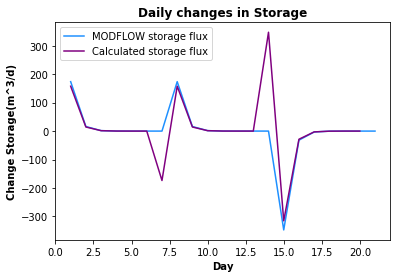

In [10]:
# Plot storage change over time
day_list = list(range(1,22))  #create list with values for each day

plt.title("Daily changes in Storage",fontweight='bold')  #set title
plt.xlabel('Day',fontweight='bold')                      #Label x axis
plt.ylabel('Change Storage(m^3/d)',fontweight='bold')    #Label y axis
plt.plot(day_list, storage_list, 'b-', color="dodgerblue", label= "MODFLOW storage flux") #plot days versus MODfLOW daily storage flux

day_list = list(range(1,21))  #create list with values for each day
plt.plot(day_list, daily_stor_change, 'b-', color="purple", label= "Calculated storage flux") #plot days versus calculated daily storage flux
# plt.savefig('storage.png', dpi=600)
plt.legend()
plt.show()  #show the figure